In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

np.random.seed(42)

# The perceptron

The perceptron is a very simple neural network that performs binary classification, e.g. try to determine whether ${\bf F}_i$ is a picture of a cat ($y_i = +1$) or a dog ($y_i = -1$). In order to train the classifier, i.e. to determine its weights ${\bf x} \in \mathbb{R}^N$, one has to solve 

$${\bf y} = \operatorname{sgn} (F {\bf x})$$

Let's put this problem in a probabilistic framework. We introduce a Gaussian noise inside the $\operatorname{sgn}$, so as to have a probit likelihood; moreover we will assume that the weights are binary, ${\bf x} \in \{+1, -1\}^N$. The full model reads

$$\left\{
\begin{aligned}
    &x_i \sim \frac12 \, \delta(x_i - 1) + \frac12 \, \delta (x_i + 1), \\
    &y_\mu \sim \frac{1}{2} \operatorname{erfc} \big( \frac{1}{\sqrt{2 \sigma^2}} {\bf F}_\mu \cdot {\bf x} \big).
\end{aligned}
\right.
$$

We start as usual by sampling from $P({\bf x}, {\bf y} | F)$.

In [3]:
def sample_instance(size_x, rows_to_columns, var_noise):
    """Samples F from P(F) and {x, y} from P(x, y | F)"""
    
    # Some pre-processing
    size_y = int(np.ceil(rows_to_columns * size_x))
    
    # Sample x from P_0(x)
    x0 = np.random.choice([+1, -1], size_x)
    
    # Generate F and y = sgn(Fx + noise)
    F = np.random.randn(size_y, size_x) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_y)
    y = np.sign(F.dot(x0) + noise)

    return x0, F, y

In [156]:
x, F, y = sample_instance(2000, 1.6, 1e-10)
print(x)
print(y)

[ 1 -1 -1 ...  1 -1  1]
[ 1.  1. -1. ...  1.  1.  1.]


## Implementing GAMP: generalized approximate message-passing

One can adapt AMP to arbitrary likelihoods $P(y | z)$. The important quantity to compute is

$$
Z_z (y, \omega, V) = \int dz \, P(y | z) \, \mathcal{N} (z; \omega, V)
$$

from which $g (y, \omega, V) = \partial_\omega \log Z_z$ can be obtained. The iteration becomes

$$
\begin{aligned}
&\omega_\mu^t = \sum_i F_{\mu i} a_i^t + V_\mu^t g(y_\mu, \omega_\mu^{t-1}, V_\mu^{t-1}), &\qquad
&V_\mu^t = \sum_i F_{\mu i}^2 c_i^t, \\
&B_i^t = A_i^t a_i^t + \sum_\mu F_{\mu i} g(y_\mu, \omega_\mu^t, V_\mu^t), &\qquad
&A_i^t = \sum_\mu F_{\mu i}^2 \partial_\omega g(y_\mu, \omega_\mu^t, V_\mu^t), \\
&a_i^{t + 1} = f_a (A_i^t, B_i^t), &\qquad
&c_i^{t + 1} = f_c (A_i^t, B_i^t).
\end{aligned}
$$

Note that for Gaussian likelihoods, $P (y | z) = \mathcal{N} (y; z, \sigma^2)$, one gets $g(y, \omega, V) = \frac{y - \omega}{V + \sigma^2}$, thus recovering the same expression as before.

In [5]:
def iterate_gamp(F, y, var_noise,
                 x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterates GAMP to solve y = sign(Fx), w/ x Rademacher"""
    
    # Some pre-processing
    size_y, size_x = F.shape
    sqrF = F * F
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    a = np.zeros(size_x)
    c = np.ones(size_x)
    
    v = np.ones(size_y)
    w = np.copy(y)
    g = np.zeros(size_y)
    dg = np.ones(size_y)
    
    a_old = np.zeros(size_x)
    
    mses = np.zeros(max_iter)
    for t in range(max_iter):
        # Iterate w and v, and compute g and g'
        g_old = np.copy(g)
        v = sqrF.dot(c)
        w = F.dot(a) - v * g_old
        g, dg = channel(y, w, v, var_noise)
        
        # Iterate A and B, and compute a and c
        a_old = np.copy(a)
        A = -sqrF.T.dot(dg)
        B = F.T.dot(g) + A * a
        a, c = prior(A, B)
        
        # Compute metrics
        diff = np.mean(np.abs(a - a_old))
        mses[t] = np.mean((a - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mses[t]))
        
        # Check for convergence
        if diff < tol or mses[t] == 0:
            break
            
    return mses

In [6]:
from scipy.special import erfcx

def prior(A, B):
    """Compute f and f' for Rademacher prior"""
    
    a = np.tanh(B)
    c = 1 - a ** 2
    return a, c

def channel(y, w, v, var_noise):
    """Compute g and g' for probit channel"""
    
    phi = -y * w / np.sqrt(2 * (v + var_noise))
    g = 2 * y / (np.sqrt(2 * np.pi * (v + var_noise)) * erfcx(phi))
    dg = -g * (w / (v + var_noise) + g)
    
    return g, dg

In [7]:
mses_gamp = iterate_gamp(F, y, var_noise=1e-10, x0=x);

t = 0, diff = 0.689799; mse = 0.428197
t = 1, diff = 0.241056; mse = 0.279662
t = 2, diff = 0.127886; mse = 0.212067
t = 3, diff = 0.0913546; mse = 0.165681
t = 4, diff = 0.0688579; mse = 0.130487
t = 5, diff = 0.0605754; mse = 0.103494
t = 6, diff = 0.0498199; mse = 0.0818637
t = 7, diff = 0.0414233; mse = 0.0613063
t = 8, diff = 0.0365946; mse = 0.0408108
t = 9, diff = 0.02819; mse = 0.0216691
t = 10, diff = 0.0211583; mse = 0.00749102
t = 11, diff = 0.00924465; mse = 1.8211e-05
t = 12, diff = 0.000203339; mse = 0


## State evolution

In [107]:
from scipy.integrate import quad
from scipy.special import erfc

def iterate_se(rows_to_columns, var_noise, max_iter=100, tol=1e-7, verbose=1):
    """Iterates state evolution associated to AMP implementation above"""
    
    # Define function to be integrated at each step
    f = lambda a: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            (1 - np.tanh(a + np.sqrt(a) * z) ** 2)
   
    def int_g(v):
        var = .5 * (1 - v) / (v + var_noise)
        g0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise)[1]
        if var == 0:
            return g0(0)
        else:
            g = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * g0(z)
            return quad(g, -10, 10)[0]
    
    v = np.zeros(max_iter)
    v[0] = 1
    
    for t in range(max_iter - 1):
        a = -rows_to_columns * int_g(v[t])
        v[t + 1] = quad(f(a), -10, 10)[0]
        
        diff = np.abs(v[t + 1] - v[t])
        if verbose:
            print("t = %d, diff = %g; v = %g" % (t, diff, v[t + 1]))
            
        if diff < tol:
            break
    
    return v

In [108]:
mses_se = iterate_se(rows_to_columns=1.494, var_noise=1e-10, max_iter=500);

t = 0, diff = 0.534595; v = 0.465405
t = 1, diff = 0.144591; v = 0.320814
t = 2, diff = 0.0635253; v = 0.257289
t = 3, diff = 0.0350835; v = 0.222205
t = 4, diff = 0.0220974; v = 0.200108
t = 5, diff = 0.0151512; v = 0.184956
t = 6, diff = 0.011022; v = 0.173934
t = 7, diff = 0.00837509; v = 0.165559
t = 8, diff = 0.0065798; v = 0.15898
t = 9, diff = 0.00530751; v = 0.153672
t = 10, diff = 0.00437369; v = 0.149298
t = 11, diff = 0.0036684; v = 0.14563
t = 12, diff = 0.00312288; v = 0.142507
t = 13, diff = 0.00269238; v = 0.139815
t = 14, diff = 0.00234674; v = 0.137468
t = 15, diff = 0.00206509; v = 0.135403
t = 16, diff = 0.00183257; v = 0.13357
t = 17, diff = 0.00163841; v = 0.131932
t = 18, diff = 0.00147464; v = 0.130457
t = 19, diff = 0.00133523; v = 0.129122
t = 20, diff = 0.00121559; v = 0.127906
t = 21, diff = 0.00111217; v = 0.126794
t = 22, diff = 0.00102217; v = 0.125772
t = 23, diff = 0.000943377; v = 0.124829
t = 24, diff = 0.000874009; v = 0.123955
t = 25, diff = 0.000812

## Free energy

In [143]:
from scipy.integrate import quad

def phi(v, rows_to_columns, var_noise=1e-10):
    """Compute replica free energy for Ising perceptron"""
    
    # Compute A(V) using SE iteration
    dg0 = lambda z: erfc(-z) * channel(+1, np.sqrt(2 * (v + var_noise)) * z, v, var_noise)[1]
    var = .5 * (1 - v) / (v + var_noise)
    if var == 0:
        a = -rows_to_columns * dg0(0)
    else:
        dg = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * dg0(z)
        a = -rows_to_columns * quad(dg, -10, 10)[0]    
    
    # Compute <log Z_z>
    lnzz0 = lambda z: erfc(z) * np.log(.5 * erfc(z))
    if var == 0:
        avg_lnzz = lnzz0(0)
    else:
        lnzz = lambda z: np.exp(-.5 * z ** 2 / var) / np.sqrt(2 * np.pi * var) * lnzz0(z)
        avg_lnzz = quad(lnzz, -10, 10)[0]

    # Compute <log Z_x>
    lnzx = lambda z: np.exp(-.5 * z ** 2) / np.sqrt(2 * np.pi) * \
            (np.log(np.cosh(a + np.sqrt(a) * z)) if np.abs(a + np.sqrt(a) * z) < 100 else \
                np.abs(a + np.sqrt(a) * z) - np.log(2))
    avg_lnzx = -.5 * a + quad(lnzx, -10, 10)[0]
    
    return .5 * a * (1 - v) - rows_to_columns * avg_lnzz - avg_lnzx

/home/ndrmnl/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


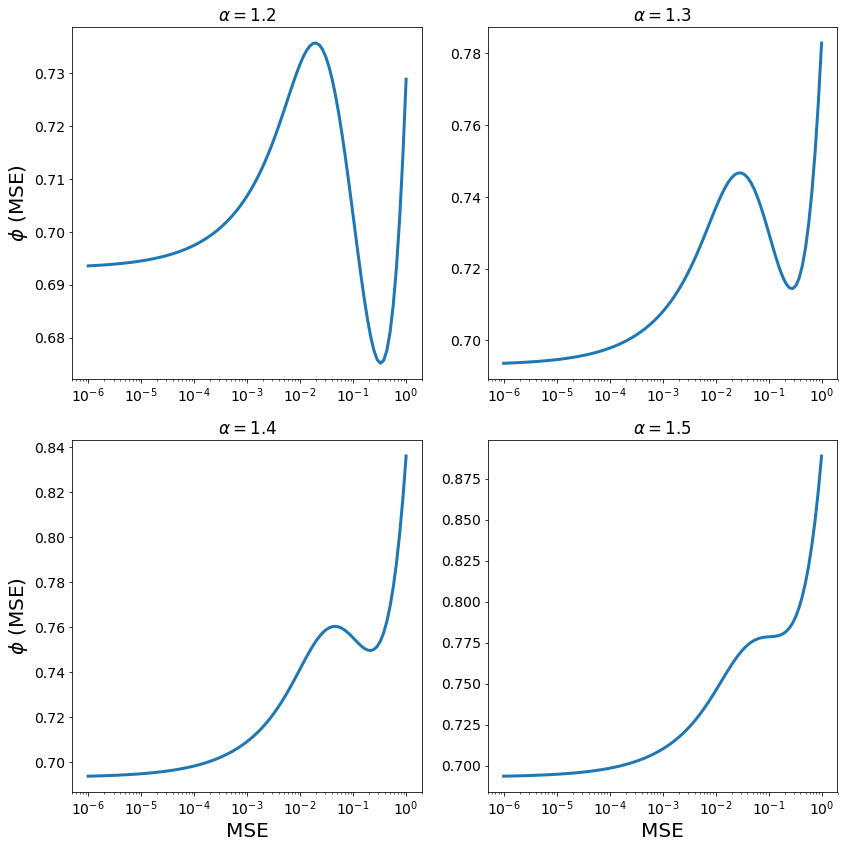

In [154]:
# Compute and plot free energy as a function of the MSE, i.e. $\phi (V)$, for many different $\alpha$
alphas = [1.2, 1.3, 1.4, 1.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for i, alpha in enumerate(alphas):
    vs = np.logspace(-6, 0, 100)
    phis = [phi(v, alpha) for v in vs]
    axs[i // 2, i % 2].semilogx(vs, phis, lw = 3)
    axs[i // 2, i % 2].set_title(r"$\alpha = %.1f$" % (alpha))
    
    # Add labels
    if i // 2 == 1:
        axs[i // 2, i % 2].set_xlabel("MSE", fontsize=20)
    if i % 2 == 0:
        axs[i // 2, i % 2].set_ylabel(r"$\phi$ (MSE)", fontsize=20)
fig.set_tight_layout(True)